<a href="https://colab.research.google.com/github/leeminq1/python_ai_colab/blob/main/%5BGAN%5DBASE%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.utils.vis_utils import plot_model



from keras.layers import Dense
from matplotlib import pyplot



### 판별 모델 정의

#### 1) sample 데이터

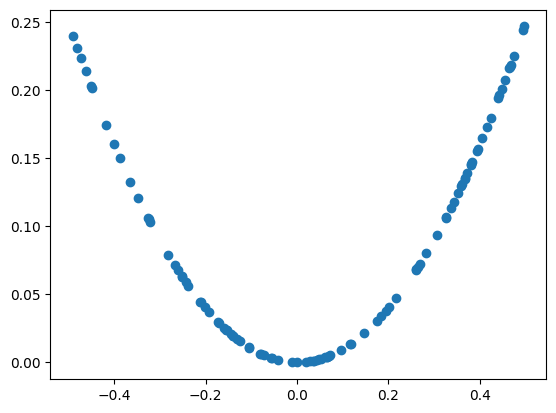

In [8]:
# example of generating random samples from X^2
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot
 
# generate randoms sample from x^2
def generate_samples(n=100):
 # generate random inputs in [-0.5, 0.5]
 X1 = rand(n) - 0.5
 # generate outputs X^2 (quadratic)
 X2 = X1 * X1
 # stack arrays
 X1 = X1.reshape(n, 1)
 X2 = X2.reshape(n, 1)
 return hstack((X1, X2))
 
# generate samples
data = generate_samples()
# plot samples
pyplot.scatter(data[:, 0], data[:, 1])
pyplot.show()

#### 2) 판별 모델 정의
 입력 : 두 개의 실제 값이 있는 샘플.
출력 : 이진 분류, 샘플이 진짜(또는 가짜)일 가능성.

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 25)                75        
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


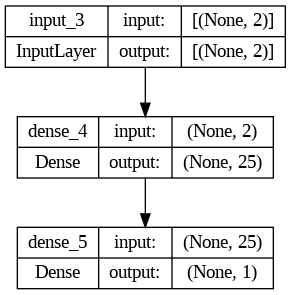

In [9]:
# define the standalone discriminator model
### 여기서 n_inputs가 들어오는 input shpae을 의미함  (batch_size, n_inputs) => (NONE,n_inputs)
def define_discriminator(n_inputs=2):
    input_size = keras.layers.Input(shape=(n_inputs,))
    x=Dense(25, activation='relu', kernel_initializer='he_uniform')(input_size)
    output=Dense(1, activation='sigmoid')(x)
    # compile model
    model = keras.models.Model(inputs=[input_size], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

 
model = define_discriminator()
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

#### 2) 실제 데이터 생성 / 가짜 데이터 생성

In [10]:
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5 
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))        ### X는 [X,X^2]의 형태를 N개의 sample을 이어 붙인 형태(axis=0) 
    # generate class labels
    y = ones((n, 1))            ### y는 실제값에 대한 label로 sample의 갯수 만큼 [1] 로 되어 있는 형태 
    return X, y

# generate n fake samples with class labels
def generate_fake_samples(n):
    # generate inputs in [-1, 1]
    X1 = -1 + rand(n) * 2
    # generate outputs in [-1, 1]
    X2 = -1 + rand(n) * 2
    # stack arrays
    X1 = X1.reshape(n, 1)  
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))   ### X는 [X,X]의 형태를 N개의 sample을 이어 붙인 형태(axis=0)  -> 가짜 데이터
    # generate class labels
    y = zeros((n, 1))
    return X, y

#### 3) 판별자 학습 (실제 label = 1 , 가짜 label = 0 )

In [11]:
# train the discriminator model
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    # run epochs manually
    for i in range(n_epochs):
      # generate real examples
      X_real, y_real = generate_real_samples(half_batch)    ### X_real_shape (half_batch, 2) -> 2는 feature 수 [x,x^2]
      # update model
      model.train_on_batch(X_real, y_real)
      # generate fake examples
      X_fake, y_fake = generate_fake_samples(half_batch)    ### X_fake_shape (half_batch, 2) -> 2는 feature 수 [x,x]
      # update model
      model.train_on_batch(X_fake, y_fake)
      # evaluate the model
      _, acc_real = model.evaluate(X_real, y_real, verbose=0)
      _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
      if i % 100 == 0:
        print(f'epoch : {i+1}, acc_real : {round(acc_real,2)*100}%, acc_fake : {round(acc_fake,2)*100}%')

# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model)

epoch : 1, acc_real : 45.0%, acc_fake : 45.0%
epoch : 101, acc_real : 47.0%, acc_fake : 55.00000000000001%
epoch : 201, acc_real : 61.0%, acc_fake : 88.0%
epoch : 301, acc_real : 52.0%, acc_fake : 95.0%
epoch : 401, acc_real : 75.0%, acc_fake : 95.0%
epoch : 501, acc_real : 91.0%, acc_fake : 91.0%
epoch : 601, acc_real : 98.0%, acc_fake : 86.0%
epoch : 701, acc_real : 98.0%, acc_fake : 91.0%
epoch : 801, acc_real : 100.0%, acc_fake : 81.0%
epoch : 901, acc_real : 100.0%, acc_fake : 83.0%


### 2) 생성자 모델 정의 
입력 : 잠재 공간의 포인트(예: 가우시안 난수의 5개 요소 벡터).
Outputs : 함수에 대해 생성된 샘플을 나타내는 2요소 벡터(x 및 x^2).

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_8 (Dense)             (None, 15)                90        
                                                                 
 dense_9 (Dense)             (None, 2)                 32        
                                                                 
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


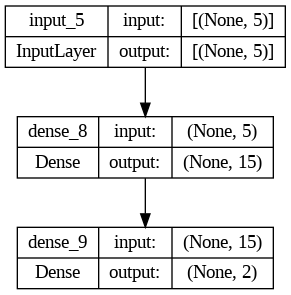

In [12]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
  input = keras.layers.Input(shape=(latent_dim,))
  x=Dense(15, activation='relu', kernel_initializer='he_uniform')(input)
  output=Dense(n_outputs, activation='linear')(x)
  model = keras.models.Model(inputs=[input], outputs=[output])

  return model

# define the discriminator model
model = define_generator(5)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

#### generator 에서 들어갈 수 있는 형태의 noise를 만들기 위한 함수로  rann 함수 (평균이 0이고 표준 편차가 1인 정규 분포에서 난수) 생성하여 noise의 초기값을 결정함

In [13]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
 # generate points in the latent space
 x_input = randn(latent_dim * n)    ### 평균 0 표준편차 1인 정규분포에서 난수를 sample 수 * latent_dim (feature수) 만큼 곱해서 생성 즉, generator에 들어가는 난수를 생성함
 # reshape into a batch of inputs for the network
 x_input = x_input.reshape(n, latent_dim)
 return x_input

위에서 생성된 (sample 수, laten_dim(feature수=5)) 인 noise vector를 generator 모델에 넣어서 output을 생성함. 여기서 output은 실제 데이터 ([x,x^2]) 의 feature 수와 같으며 이는 discriminator의 input과 동일함 

In [16]:
## 여기서는 noise = latent_dim의 n개의 sample에서 generator를 통해서 실제 output과 동일한 
## X의 배열은 (n샘플수 , [X,X^2]) 과 동일한 shape (n,2) 이다 
# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
 # generate points in latent space
 x_input = generate_latent_points(latent_dim, n)
 # predict outputs
 X = generator.predict(x_input)
 # plot the results
 pyplot.scatter(X[:, 0], X[:, 1])
 pyplot.show()

## 여기서는 단순히 generator를 통해 fake sample을 생성한다.

4/4 [==============================] - 0s 5ms/step


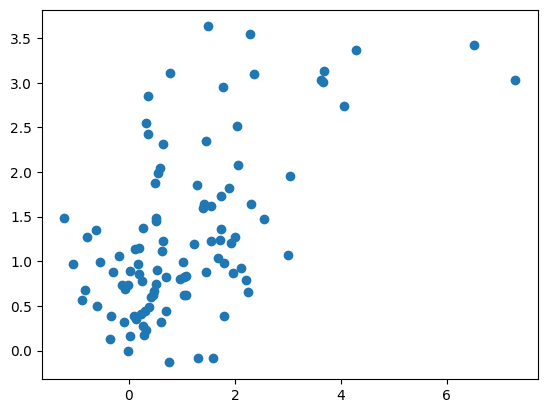

In [17]:
# size of the latent space
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)

## generator 모델 학습

In [22]:
### generator가 공급하고 discriminator 가 판별하는 전체 pipe line 모델 생성
## 위에서는 discriminator 를 먼저 학습하고 학습된 disciriminator를 사용함.
## 판별기 모델은 -> 진짜와 가짜 예제에 대한 판별기 성능에 관심
## 생성기 모델은 -> 가짜 예제에 대한 판별기의 성능에만 관심
## generator가 학습할 때 생성된 샘플을 실제 class = 1 로 표시 
## -> 실제라고 생성한 데이터를 판별기에서는 0.3, 0.5와 같이 낮은 확률로 분류함 
## 이때의 오류는 큰 값으로 오류 수정을 위해서 generator의 가중치만 업데이트하여 
## 생성기가 더 그럴 듯한 샘플을 생성하도록 학습하

In [23]:
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_9 (Functional)        (None, 2)                 122       
                                                                 
 model_8 (Functional)        (None, 1)                 101       
                                                                 
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


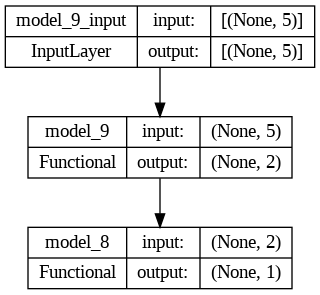

In [25]:
#size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
#### generator 만 업데이트하고 discriminator는 업데이트 하지 않음
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator's error
    gan_model.train_on_batch(x_gan, y_gan)

In [27]:
### generator & discriminaator를 둘다 업데이트 하는 함수
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
  # determine half the size of one batch, for updating the discriminator
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
    # update discriminator
    d_model.train_on_batch(x_real, y_real)
    d_model.train_on_batch(x_fake, y_fake)
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
    # update the generator via the discriminator's error
    gan_model.train_on_batch(x_gan, y_gan)

1999 0.6000000238418579 0.47999998927116394


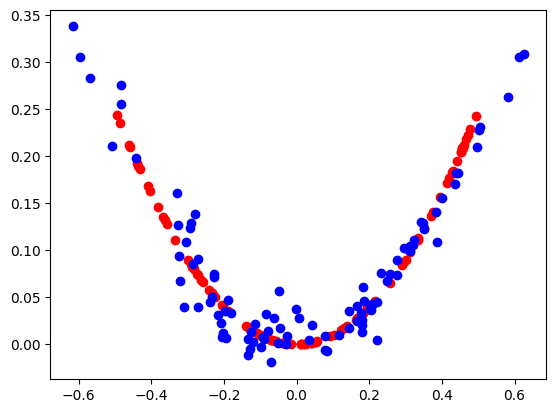

3999 0.6100000143051147 0.44999998807907104


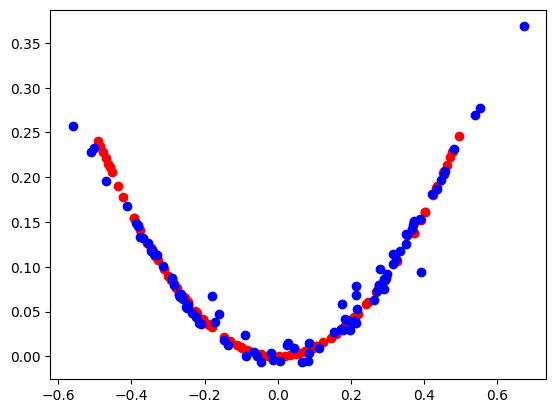

5999 0.699999988079071 0.5099999904632568


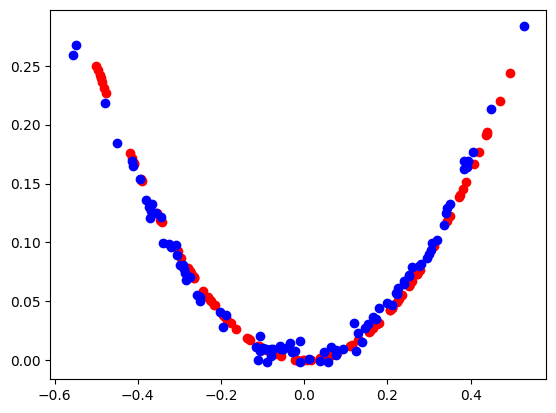

7999 0.6299999952316284 0.5699999928474426


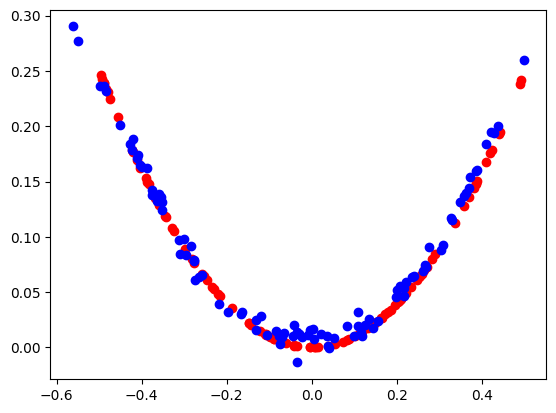

9999 0.6499999761581421 0.6100000143051147


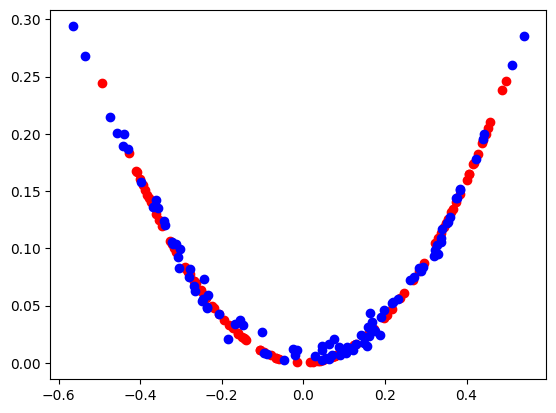

11999 0.5699999928474426 0.6100000143051147


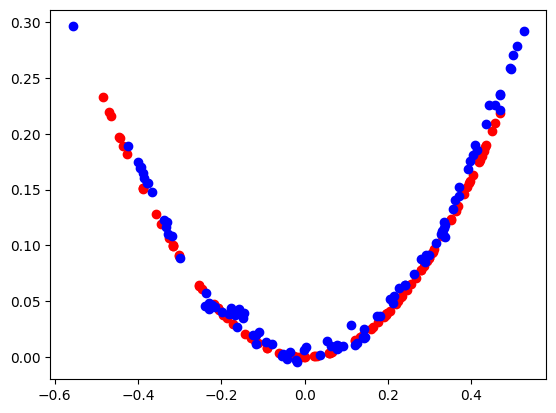

13999 0.6000000238418579 0.47999998927116394


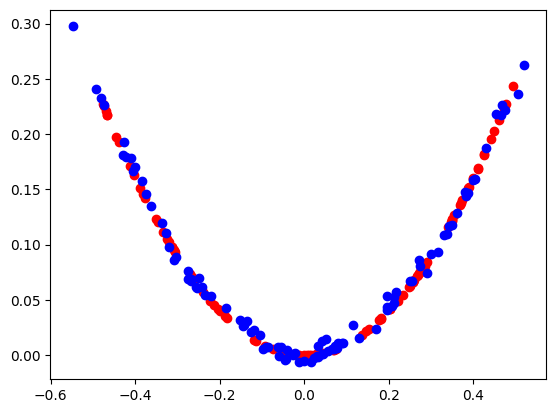

15999 0.6800000071525574 0.550000011920929


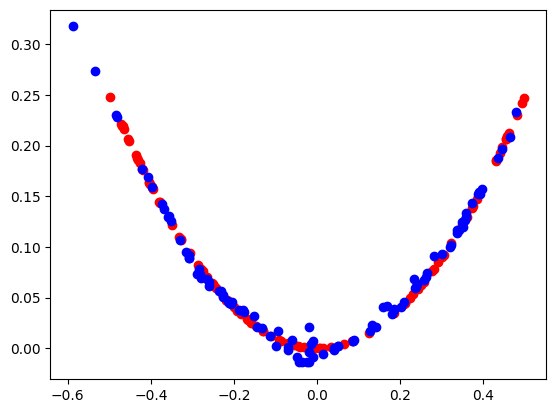

17999 0.4399999976158142 0.5899999737739563


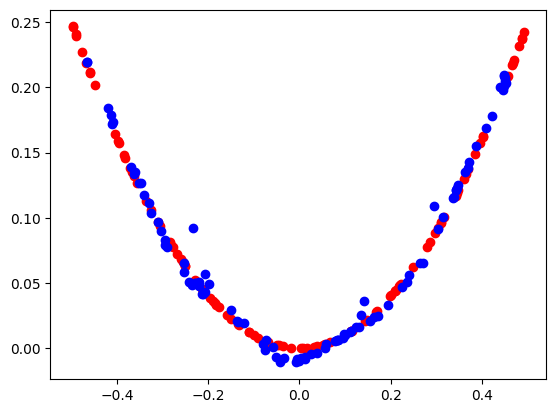

19999 0.5600000023841858 0.6399999856948853


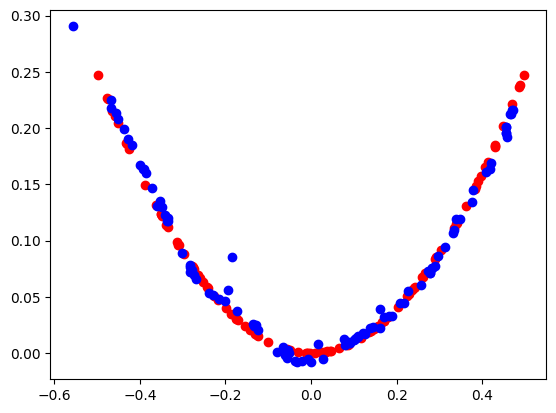

In [30]:
######### 전체모델
### discriminator는 half batch로 조금만 업데이트 시키고
### generator는 batch로 많은 샘플을 생성함.
### 이는 discriminator를 학습을 덜 시키고 generator 학습을 많이시켜서 
### generator 가 학습이 잘되게 하기 위함임


from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
 
# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
 
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    X1 = rand(n) - 0.5
    # generate outputs X^2
    X2 = X1 * X1
    # stack arrays
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # generate class labels
    y = ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input,verbose=0)
    # create class labels
    y = zeros((n, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=20000, n_batch=128, n_eval=2000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
          summarize_performance(i, g_model, d_model, latent_dim)
 
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)
